In [1]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.fair import BinaryFair
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from tqdm.auto import trange

%load_ext autoreload
%autoreload 2

In [2]:
data_file = torch.load("data/Crime/data.pt")

/home/jt/miniconda3/envs/fnf4hep/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jt/miniconda3/envs/fnf4hep/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


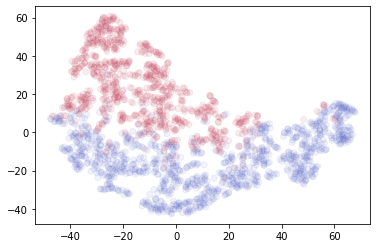

In [3]:
X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [4]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Split data by label
data_0 = data_file['data'][data_file['labels'].flatten() == 0]
context_0 = data_file['data'][data_file['labels'].flatten() == 0]

data_1 = data_file['data'][data_file['labels'].flatten() == 1]
context_1 = data_file['data'][data_file['labels'].flatten() == 1]

# Generators
label_0_set = TensorDataset(data_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)


In [5]:
gamma = 0.05
Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                  context_dim=None, 
                  flow_n_layers = 3,
                  flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                  classifier_hidden_dim = 32,
                  classifier_n_layers = 4,
                  classifier_activation = 'ReLU',
                  gamma=gamma
                 )
optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [6]:
n_steps = 100
Fair.train()
for n_step in trange(n_steps):
    data_0, labels_0 = next(iter(label_0_generator))
    data_1, labels_1 = next(iter(label_1_generator))
    
    optimizer.zero_grad()

    L_KL, L_clf, loss = Fair.loss(data_0, data_1, context_0=None, context_1=None, return_all_losses=True)

    total_losses.append(loss.item())
    KL_losses.append(L_KL.item())
    clf_losses.append(L_clf.item())

    loss.backward()
    optimizer.step()
Fair.eval();

100%|██████████| 1000/1000 [00:14<00:00, 70.35it/s]


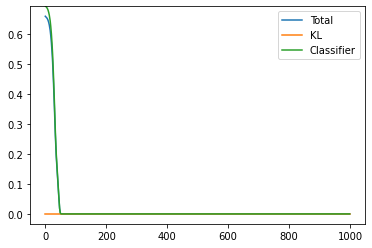

In [7]:
plt.plot(total_losses, label="Total")
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(KL_losses, label="KL")
plt.plot(clf_losses, label="Classifier")
plt.legend()
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.show()

In [12]:

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=None, context_1=None)

labels = torch.cat(
    [torch.zeros(embedding_0.shape[0], 1), torch.ones(embedding_1.shape[0], 1)]
)

embds = torch.cat([embedding_0, embedding_1])
label_preds = Fair.classifier.forward(embds).sigmoid()

label_preds



tensor([[2.0018e-19],
        [2.3568e-18],
        [4.4088e-19],
        [1.7596e-17],
        [5.3185e-15],
        [1.6304e-17],
        [9.7234e-15],
        [1.4499e-19],
        [1.0090e-18],
        [4.1655e-15],
        [2.4822e-17],
        [1.6581e-19],
        [5.3322e-17],
        [6.0088e-19],
        [1.1652e-13],
        [1.2091e-16],
        [1.2373e-17],
        [2.7036e-14],
        [3.1262e-20],
        [3.9511e-16],
        [4.6534e-13],
        [2.2178e-18],
        [3.4778e-18],
        [5.1184e-16],
        [3.2097e-17],
        [1.7604e-17],
        [3.2322e-18],
        [2.1460e-18],
        [6.8666e-18],
        [2.3815e-18],
        [4.7368e-14],
        [5.0595e-19],
        [1.8811e-19],
        [9.3106e-20],
        [1.0111e-18],
        [3.3557e-15],
        [5.0552e-11],
        [3.8778e-17],
        [3.3194e-15],
        [2.3448e-16],
        [1.1387e-17],
        [6.2407e-20],
        [1.3760e-19],
        [2.1852e-12],
        [1.7873e-12],
        [3

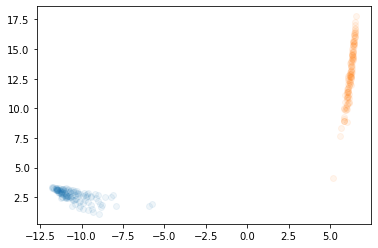

In [17]:
plt.scatter(*embedding_0.T[:2].detach(), alpha=0.07, cmap='coolwarm')
plt.scatter(*embedding_1.T[:2].detach(), alpha=0.07, cmap="redblue")


In [8]:
Fair.sample(2)

tensor([[-1.2296e+00,  6.1986e+00,  6.0353e-01, -5.1366e+00, -4.0344e+00,
          4.7552e+00],
        [ 1.0082e+05, -7.4753e+02,  8.1448e+01,  2.8092e+01, -2.9816e+00,
         -1.0596e+00]], grad_fn=<AddBackward0>)

In [9]:
with torch.no_grad():
    cont_pred = Fair(data_file['data'], data_file['context']).sigmoid()
    bin_pred = (cont_pred > 0.5).int()
    acc = accuracy_score(bin_pred, data_file['labels'])
acc

NotImplementedError: 

Accuracies:
    gamma = 0. : 0.84  # paper achieves 85.2 (not too far off)
    gamma = 1. : 0.5

In [ ]:
with torch.no_grad():
    embedding = Fair.embed(data_file['data'], data_file['context'])[0]
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.02, cmap='coolwarm')

In [ ]:
with torch.no_grad():
    embedding = Fair.embed(data_file['data'], 0*data_file['context'])[0]
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.02, cmap='coolwarm')

In [ ]:
with torch.no_grad():
    embedding = Fair._embed(data_file['data'])[0]
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.02, cmap='coolwarm')

In [ ]:
n_samples = 1000
with torch.no_grad():
    samples_0 = Fair.sample(1, context=torch.zeros(n_samples, 1)).squeeze(1)
    samples_1 = Fair.sample(1, context=torch.ones(n_samples, 1)).squeeze(1)
EmpiricalStatisticalDistance(samples_0, samples_1, 
                             hidden_dim=32, n_layers=2, n_epochs=100)